In [0]:
!pip install git+https://github.com/sevamoo/SOMPY
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

  Cloning https://github.com/sevamoo/SOMPY to /tmp/pip-req-build-2ku2on2n
  Running command git clone -q https://github.com/sevamoo/SOMPY /tmp/pip-req-build-2ku2on2n
  Created wheel for SOMPY: filename=SOMPY-1.1-cp36-none-any.whl size=28115 sha256=56e5f16f6338383efefa0d18180bf8b52fe49816f518a914218add71b6bea52e
  Stored in directory: /tmp/pip-ephem-wheel-cache-hy4rolj_/wheels/89/eb/f9/61aa37e7c35ddc5fdaeb57dae54241a1a80bdd472cce3024fa
Successfully built SOMPY


In [0]:
link = 'https://drive.google.com/open?id=1LU02Q_LhK1ssmiNgGkvTD2YskNuBSr-T'
fluff, id = link.split('=')

En este archivo se va a proceder a realizar un análisis clúster sobre la base de datos del crecimiento del PIB mundial por países. Para ello, se ha usado la base de datos del Banco Mundial.

Se ha limpiado previamente de datos que eran agregaciones por territorios y de observaciones que no tenían datos para ninguno de los años. También se ha acortado el periodo para dejarlo entre el 2004 y 2017

También se eliminan Lybia y Timor-Leste por suponer datos atípicos e irregulares.

In [0]:
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('PIBL.csv')  
df = pd.read_csv('PIBL.csv', delimiter=';')
df = df.set_index('Country Name')
df = df.iloc[:,1:(len(df.columns)-1)]
df = df.drop(["Libya"], axis=0)
df = df.drop(["Timor-Leste"], axis=0)

El primer clúster que se realizará será mediante la técnica de los Self Organizing Maps o mapas SOM. Para determinar el tamaño del mapa se va a poner un tamaño de celdas un poco más amplio que el número de observaciones, que es un criterio ya observado en algunos otros análisis.

In [0]:
import sompy as sompy
mapsize = [15,15]
som = sompy.SOMFactory.build(df.values, mapsize, mask=None, mapshape='planar', lattice='rect', normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=10, verbose='info')  # verbose='debug' will print more, and verbose=None wont print anything

 Training...
 pca_linear_initialization took: 0.015000 seconds
 Rough training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 34

 epoch: 1 ---> elapsed time:  0.118000, quantization error: 2.261600

 epoch: 2 ---> elapsed time:  0.111000, quantization error: 2.128660

 epoch: 3 ---> elapsed time:  0.111000, quantization error: 2.111260

 epoch: 4 ---> elapsed time:  0.115000, quantization error: 2.079457

 epoch: 5 ---> elapsed time:  0.110000, quantization error: 2.060808

 epoch: 6 ---> elapsed time:  0.108000, quantization error: 2.044954

 epoch: 7 ---> elapsed time:  0.107000, quantization error: 2.031685

 epoch: 8 ---> elapsed time:  0.107000, quantization error: 2.017947

 epoch: 9 ---> elapsed time:  0.107000, quantization error: 2.004894

 epoch: 10 ---> elapsed time:  0.107000, quantization error: 1.993992

 epoch: 11 ---> elapsed time:  0.107000, quantization error: 1.983679

 epoch: 12 ---> elapsed time:  0.108000, quantization error: 1.973401

 epoch: 13 --

En estos mapas se observa un mapa de calor por cada uno de los años, de dos formas distintas:

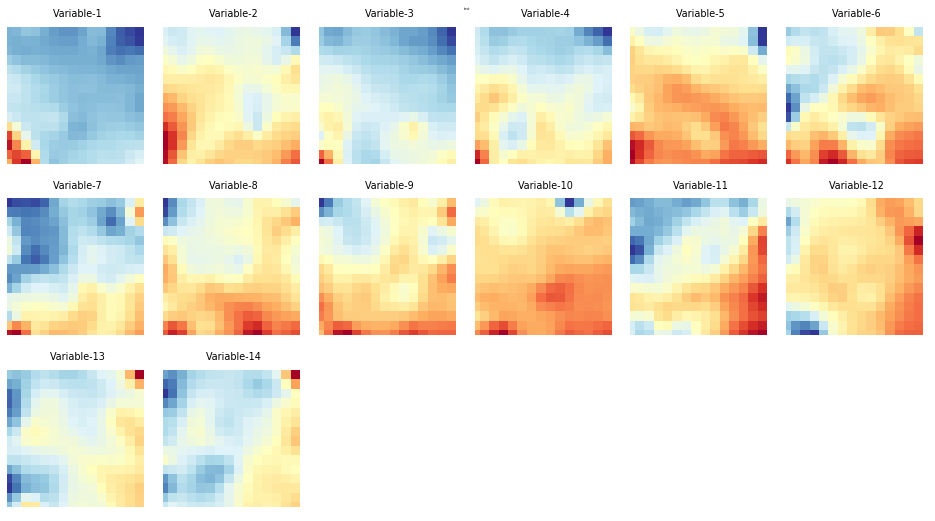

In [0]:
v = sompy.mapview.View2DPacked(50, 50, 'test',text_size=8)  
# could be done in a one-liner: sompy.mapview.View2DPacked(300, 300, 'test').show(som)
v.show(som, what='codebook', which_dim='all', cmap=None, col_sz=6) 
# v.save('2d_packed_test')

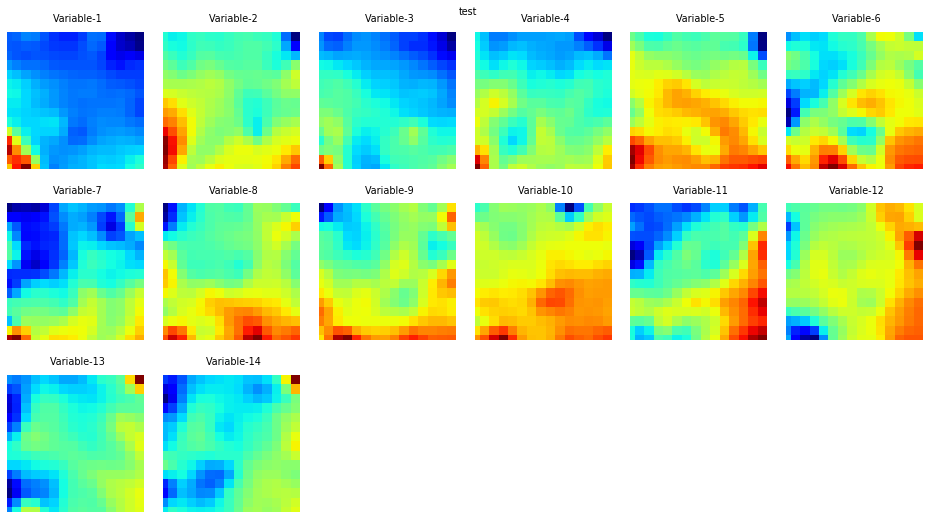

In [0]:
# som.component_names = ['Variable-1','Variable-2']
v = sompy.mapview.View2DPacked(50, 50, 'test',text_size=8)  
v.show(som, what='codebook', which_dim='all', cmap='jet', col_sz=6) #which_dim='all' default

Este análisis SOM ha sacado un valor de celda para cada individuo. Dado que este valor por sí solo es bastante desagregado (hay un número alto de individuos que se encuentra completamente solo en las celdas) se ha optado por realizar una segunda agregación:

In [0]:
# c = sompy.mapview.View2DPacked()
v = sompy.mapview.View2DPacked(2, 2, 'test',text_size=8)  
#first you can do clustering. Currently only K-means on top of the trained som
cl = som.cluster(n_clusters=4)
# print cl
getattr(som, 'cluster_labels')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 0,
       0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=int32)

/usr/local/lib/python3.6/dist-packages/sompy/visualization/hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


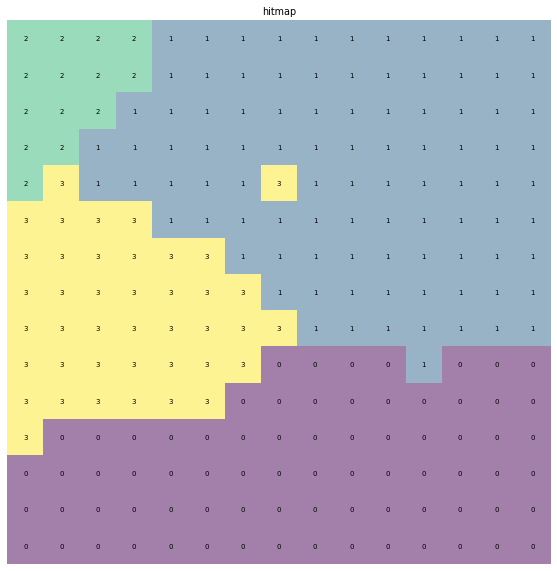

In [0]:
h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)

# Encontras k nodos más cercanos y sus distancias

Podemos encontrar tambien los k nodos más cercanos a cada observación, aunque en este análisis no entraremos más en profundidad.

Esto puede servir para, por ejemplo, observar qué vecinos tiene más cerca cada observación.

In [0]:
som.find_k_nodes(df, k=1)

# Encontrar los valores BMU, que es el vector de celdas que está más cerca de un determinado dato

In [0]:
som.find_bmu(df)

In [0]:
pd.value_counts((som.find_bmu(df)[0])).sum()

201

# Matriz U

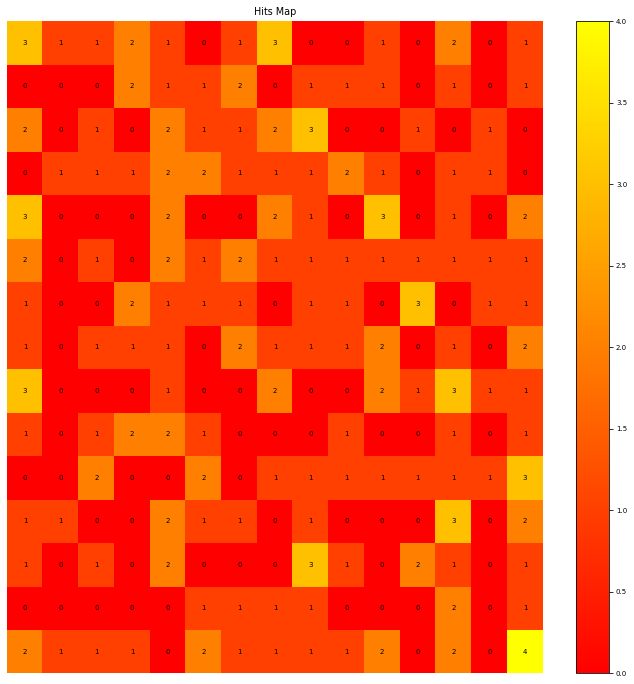

In [0]:
from sompy.visualization.bmuhits import BmuHitsView
import matplotlib.pyplot as plt
#sm.codebook.lattice="rect"
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(som, anotate=True, onlyzeros=False, labelsize=7, cmap="autumn", logaritmic=False)
plt.show()

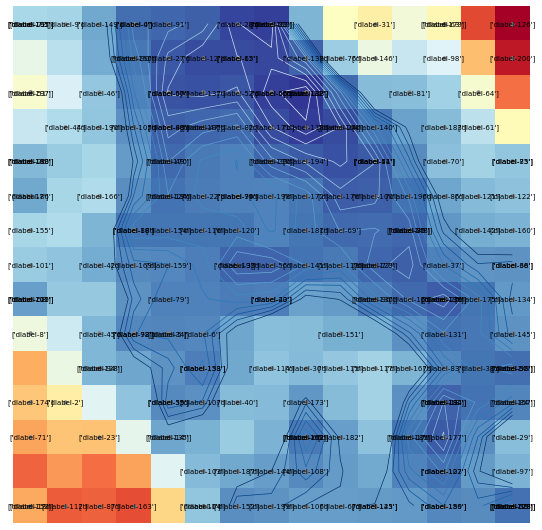

([], array([[0.85263913, 0.83868587, 0.65575705, 0.46246116, 0.43754953,
         0.41876854, 0.33748626, 0.31967131, 0.70155968, 1.22002805,
         1.32173043, 1.14527269, 1.27948881, 1.9053082 , 2.17031846],
        [1.09796053, 0.90756409, 0.67039255, 0.48944344, 0.3996282 ,
         0.36063102, 0.36126175, 0.34384155, 0.42410669, 0.80610082,
         1.11509373, 0.95368822, 1.0394111 , 1.5457835 , 2.07420324],
        [1.18104736, 1.03016564, 0.7813492 , 0.52461102, 0.37972898,
         0.37518013, 0.3867998 , 0.32027857, 0.29003839, 0.44575568,
         0.73121324, 0.74082044, 0.82140107, 1.17215485, 1.78197834],
        [0.95151471, 0.8754164 , 0.77147727, 0.56942288, 0.41831024,
         0.44129169, 0.4562319 , 0.359253  , 0.31869138, 0.35950154,
         0.49237321, 0.62820011, 0.73677122, 0.91611635, 1.25890314],
        [0.72047751, 0.80263204, 0.84802415, 0.60903695, 0.45130814,
         0.50242162, 0.52249866, 0.43719773, 0.40136805, 0.37729745,
         0.40472413, 0.560

In [0]:
umat = sompy.umatrix.UMatrixView(distance=1,  row_normalized=True, width=200, height=200, title="UMatrix")
umat.show(som, show_data=True, labels=True)

# Hacer un clúster del SOM

In [0]:
random_state=1
clust = pd.DataFrame(som.cluster(n_clusters=5))
clust['index'] = clust.index

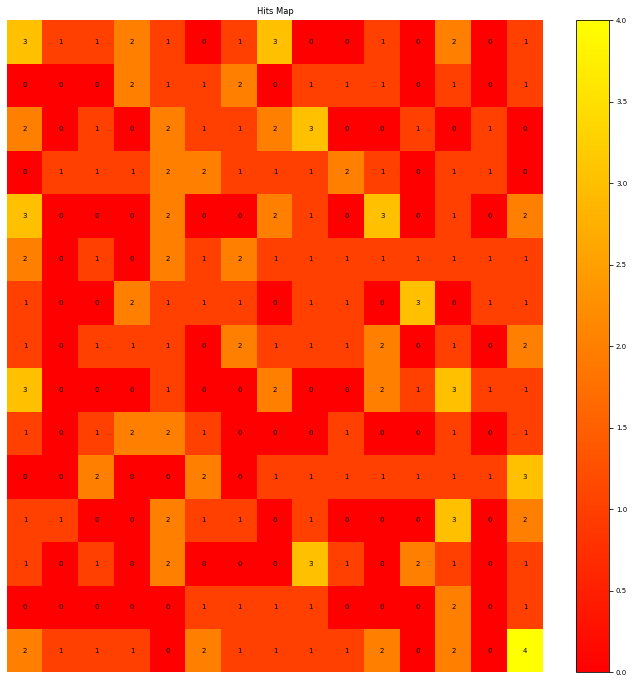

In [0]:
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(som, anotate=True, onlyzeros=False, labelsize=7, cmap="autumn", logaritmic=False)
plt.show()

/usr/local/lib/python3.6/dist-packages/sompy/visualization/hitmap.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = self._fig.add_subplot(111)


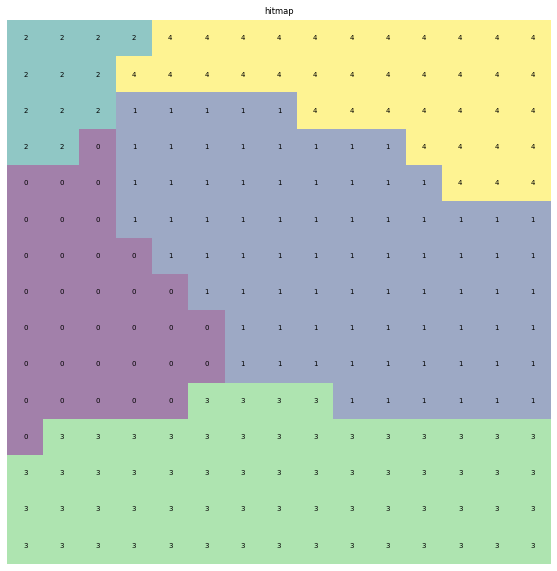

In [0]:
cl = som.cluster(n_clusters=5)
h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)

In [0]:
nodes =  pd.DataFrame(som.find_k_nodes(df, k=1)[1])
a=nodes.copy()
pd.value_counts(nodes[0])[0:30]

NumExpr defaulting to 2 threads.


224    4
188    3
7      3
38     3
60     3
70     3
101    3
120    3
132    3
164    3
177    3
0      3
139    2
37     2
67     2
30     2
222    2
34     2
64     2
155    2
152    2
111    2
74     2
138    2
54     2
115    2
49     2
50     2
119    2
130    2
Name: 0, dtype: int64

In [0]:
nodes.index = df.index
nodes.columns = ['index']
cluster2 = pd.merge(nodes, clust, how='left', on="index")
cluster2.index = nodes.index
cluster_tot = pd.merge(cluster2, df, on=df.index)

Una vez hecha la agregación del clúster SOM en varios clústeres, se representan:

In [0]:
cluster_tot[cluster_tot[0]==0]

,key_0,index,0,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
3,Albania,111,0,5.509999,5.529915,5.900084,5.979982,7.499970,3.349994,3.706881,2.545405,1.417526,1.001988,1.770000,2.230000,3.350000,3.836620
5,Arab World,139,0,9.343619,5.716352,6.496294,4.571479,5.819175,0.428317,4.772079,3.629086,6.656678,3.166151,2.455201,3.307618,3.247325,0.999882
6,United Arab Emirates,140,0,9.566437,4.855141,9.837320,3.184390,3.191836,-5.242922,1.602810,6.930272,4.484626,5.053346,4.398697,5.064702,2.988442,0.790400
11,Australia,70,0,4.055503,3.204199,2.794529,3.844301,3.657944,1.936905,2.067520,2.462725,3.900900,2.615722,2.568707,2.336075,2.846755,2.342582
14,Burundi,184,0,4.833658,0.900000,5.413807,3.451952,4.861713,3.812747,5.124163,4.032602,4.446708,4.924195,4.240652,-3.900003,-0.600020,0.500010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,Thailand,84,0,6.289289,4.187835,4.967917,5.435093,1.725668,-0.690733,7.513591,0.839959,7.242787,2.687380,0.984414,3.133897,3.356489,4.024086
181,Tunisia,98,0,6.235794,3.486536,5.244195,6.709620,4.237777,3.043449,3.510609,-1.917178,3.997674,2.875524,2.971398,1.194542,1.262529,1.824675
193,Vanuatu,111,0,3.984755,5.302852,8.465160,5.173513,6.448521,3.312816,1.629082,1.223226,1.754750,1.969146,2.331006,-0.801094,4.000574,4.500680
196,Kosovo,86,0,2.612127,6.033230,4.503032,7.286083,2.644819,3.341666,3.309575,4.812563,2.895349,3.431230,1.198071,4.094455,4.056579,4.227909


In [0]:
cluster_tot[cluster_tot[0]==1]

,key_0,index,0,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
2,Angola,166,1,10.952862,15.028915,11.547683,14.010018,11.166138,0.858713,4.859220,3.471981,8.542147,4.954590,4.822626,0.943576,-2.580097,-0.147207
13,Azerbaijan,210,1,9.253801,27.961538,34.466209,25.463216,10.591437,9.369503,4.788833,-1.572998,2.202939,5.842673,2.797289,1.050751,-3.064200,-0.282011
23,Belarus,182,1,11.449743,9.400002,9.999995,8.600007,10.199999,0.199995,7.798267,5.378707,1.687136,1.003471,1.726385,-3.829571,-2.526446,2.532183
71,Equatorial Guinea,180,1,37.998727,16.748701,7.704918,15.282114,17.799109,1.343356,-8.924176,6.523924,8.312872,-4.133199,0.415066,-9.110041,-8.816417,-4.685684
87,Iraq,212,1,54.157774,4.400617,10.158199,1.377598,8.228107,3.379299,6.402565,7.546471,13.936430,7.600000,0.700000,2.477665,13.572219,-1.671287
112,Macao SAR China,211,1,26.754434,8.060186,13.313893,14.447617,3.393746,1.321131,25.263881,21.672436,9.237400,11.200068,-1.201086,-21.594488,-0.858022,9.703993
153,Qatar,210,1,19.218915,7.492759,26.170246,17.985657,17.663556,11.956561,19.592332,13.375176,4.687259,4.410275,3.978882,3.657510,2.131311,1.579850
163,Sierra Leone,213,1,6.597945,4.505096,4.223914,8.058145,5.398285,3.188051,5.346466,6.315045,15.181769,20.715768,4.556772,-20.598771,6.055474,4.211183
174,Chad,165,1,33.629372,17.332534,0.648262,3.271500,3.052692,4.217696,13.550101,0.082870,8.882576,5.700001,6.899985,2.767676,-6.255527,-2.988696


In [0]:
cluster_tot[cluster_tot[0]==2]

,key_0,index,0,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
7,Argentina,75,2,9.029573,8.851660,8.047152,9.007651,4.057233,-5.918525,10.125398,6.003952,-1.026420,2.405324,-2.512615,2.731160,-2.080328,2.668590
8,Armenia,135,2,10.467842,13.865711,13.198004,13.749202,6.900000,-14.149989,2.200000,4.700000,7.200000,3.300000,3.600000,3.200000,0.200000,7.500000
10,Antigua and Barbuda,93,2,5.736460,6.412405,12.728507,9.259421,-0.030133,-12.107536,-7.200024,-2.079127,3.506609,-0.103865,4.658127,4.025737,5.589741,3.032606
19,Bulgaria,79,2,6.435358,7.123511,6.874358,7.344422,6.021883,-3.586146,1.324088,1.914906,0.030970,0.493921,1.837521,3.471186,3.936758,3.811248
22,Bosnia and Herzegovina,80,2,6.099967,8.759257,5.417270,5.855585,5.426727,-3.002753,0.872151,0.958953,-0.821729,2.351034,1.148038,3.088224,3.145658,3.163559
26,Brazil,60,2,5.759965,3.202131,3.961989,6.069871,5.094195,-0.125812,7.528226,3.974423,1.921176,3.004823,0.503956,-3.545763,-3.305454,1.063861
42,Cabo Verde,107,2,10.197073,6.912458,7.983750,15.170688,6.650521,-1.270426,1.466790,3.968886,1.081918,0.802798,0.611213,1.006864,4.705792,4.013257
45,Cuba,137,2,5.770538,11.201656,12.065863,7.262137,4.116828,1.451305,2.390352,2.802301,3.014900,2.747603,1.047577,4.438142,0.513761,1.783498
49,Czech Republic,64,2,4.906564,6.533469,6.853522,5.602644,2.682283,-4.802572,2.273420,1.777833,-0.799844,-0.483671,2.715116,5.309239,2.450542,4.352604
58,Estonia,120,2,6.294746,9.373711,10.271884,7.748192,-5.419456,-14.724404,2.259076,7.597300,4.307259,1.936543,2.888564,1.900287,3.489097,4.856687


In [0]:
cluster_tot[cluster_tot[0]==3]

,key_0,index,0,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,3,3,7.911565,1.214349,1.050607,1.800226,-0.090708,-10.519748,-3.685030,3.446055,-1.369863,4.198232,0.848228,-0.450586,-0.211225,1.330511
4,Andorra,3,3,7.647870,7.396983,4.536353,0.040011,-8.590004,-3.690654,-5.358826,-4.646543,-1.615218,0.351645,2.277683,0.842204,1.889124,1.724022
9,American Samoa,1,3,0.538358,-0.401606,-4.166667,1.963534,-2.613480,-4.237288,0.442478,0.293686,-4.392387,-2.756508,0.944882,1.248050,-2.619414,-5.379747
12,Austria,20,3,2.735119,2.244067,3.454041,3.727415,1.460425,-3.764580,1.837095,2.922798,0.680444,0.025504,0.661275,1.142980,2.039575,2.550881
15,Belgium,21,3,3.634853,2.094266,2.506140,3.448976,0.783158,-2.253172,2.744231,1.798306,0.234779,0.200662,1.254677,1.739580,1.452552,1.734390
21,Bahamas The,7,3,0.882840,3.395356,2.516849,1.446545,-2.323967,-4.175260,1.538777,0.612897,3.086687,-0.410429,-0.147989,1.044960,-1.689550,1.437191
24,Belize,54,3,4.648087,2.578009,4.581600,1.105586,3.228856,0.670801,3.383472,2.162607,2.937813,0.851935,3.692371,3.431950,-0.588024,1.437289
27,Barbados,19,3,1.406905,3.975204,5.668591,1.764284,0.123207,-3.972928,0.265446,0.657294,0.281154,0.009044,0.018086,0.904159,2.007168,1.000000
28,Brunei Darussalam,6,3,0.504318,0.387507,4.397720,0.154582,-1.939715,-1.764536,2.598966,3.745318,0.912842,-2.126029,-2.349747,-0.566815,-2.465515,1.328751
31,Central African Republic,10,3,5.994884,0.908211,4.771085,4.607535,2.054131,8.587260,4.630818,4.194615,5.053761,-36.037426,0.117267,4.562808,5.006286,4.457283


In [0]:
cluster_tot[cluster_tot[0]==4]

,key_0,index,0,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,Afghanistan,215,4,1.414118,11.229715,5.357403,13.826320,3.924984,21.390528,14.362441,0.426355,12.752287,5.600745,2.724543,1.451315,2.260314,2.665292
17,Burkina Faso,191,4,4.478474,8.661862,6.253159,5.655005,7.294498,2.962014,5.373373,6.626865,6.452699,5.792589,4.326837,3.894548,5.934135,6.302096
18,Bangladesh,177,4,5.239533,6.535945,6.671905,7.058599,6.013790,5.045125,5.571802,6.464384,6.521435,6.013610,6.061059,6.552653,7.113489,7.284184
29,Bhutan,194,4,5.896408,7.122560,6.849366,17.925825,4.768354,6.657224,11.730854,7.890914,5.071710,2.142497,5.745455,6.644564,8.022101,4.629101
35,China,224,4,10.111223,11.395776,12.719479,14.231388,9.654289,9.399813,10.636140,9.550914,7.859627,7.768615,7.299519,6.905317,6.736675,6.757008
38,Congo Dem. Rep.,163,4,6.738374,6.135151,5.320980,6.259478,6.225894,2.855064,7.107977,6.874671,7.086899,8.481957,9.470288,6.916188,2.399379,3.726948
53,Dominican Republic,164,4,2.570134,9.428237,9.174355,7.415952,3.209504,0.946155,8.339651,3.133423,2.717368,4.875205,7.636032,7.033371,6.612208,4.551815
59,Ethiopia,224,4,13.572603,11.818766,10.834727,11.456167,10.788522,8.802553,12.550538,11.178296,8.647812,10.582270,10.257493,10.392463,9.433483,9.503859
66,Georgia,188,4,5.794496,9.589574,9.419771,12.578953,2.418572,-3.650514,6.249488,7.221609,6.350798,3.386771,4.623613,2.880527,2.846603,4.832686
67,Ghana,219,4,5.600000,5.900004,6.399913,4.346819,9.149799,4.844487,7.899712,14.047124,9.292789,7.312525,2.897439,2.178207,3.447793,8.143446


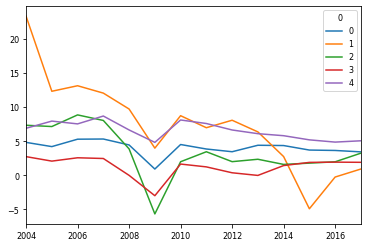

In [0]:
import numpy as np
np.transpose(cluster_tot.groupby(0).mean().iloc[[0,1,2,3,4],1:17]).plot()

Parece que el clúster engloba bien a los países que crecen rápido (China, Taiwán, etc.), los que mantienen un ritmo acelerado pero no tan rápido (Australia, Emiratos Árabes), los que tienen un ritmo más bajo (países desarrollados como Francia o Gran Bretaña) y los países más inestables (Argentina, Ucrania, etc.)

`The value v is the vector in the SOM that corresponds to the current U-Matrix cell. Each adjacent cell in the SOM (above, below, left, right) is processed and the sum of the Euclidean distances is computed:`

# Fourier

También se ha realizado un clúster con kMeans a partir de la transformada rápida de Fourier, cogiendo la parte real y clusterizando sobre ella

In [0]:
import numpy.fft as npfft
ff = npfft.fft(df)
FR = pd.DataFrame(ff)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
sp2 = np.fft.fft(df2['KWh'])
freq2 = np.fft.fftfreq(df2['KWh'].shape[-1])
plt.plot(freq2, sp2.real, freq2, sp2.imag)

plt.show()

In [0]:
xs

array([0.00000000e+00, 1.00010001e-04, 2.00020002e-04, ...,
       9.99799980e-01, 9.99899990e-01, 1.00000000e+00])

In [0]:
FReal = pd.concat([FR.apply(lambda x: x.real)], 
               axis=1, 
               keys=('R','X')) \
       .swaplevel(0,1,1) \
       .sort_index(1)

FImag = pd.concat([FR.apply(lambda x: x.imag)], 
               axis=1, 
               keys=('X')) \
       .swaplevel(0,1,1) \
       .sort_index(1)

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
matrix = pd.DataFrame(FReal)
for n_clusters in range(2,16):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.2611418354655042
For n_clusters = 3 The average silhouette_score is : 0.27791936133740786
For n_clusters = 4 The average silhouette_score is : 0.22515909321650426
For n_clusters = 5 The average silhouette_score is : 0.21101673267311916
For n_clusters = 6 The average silhouette_score is : 0.21493456559855129
For n_clusters = 7 The average silhouette_score is : 0.1985910073168202
For n_clusters = 8 The average silhouette_score is : 0.18223271303896166
For n_clusters = 9 The average silhouette_score is : 0.19253655507766573
For n_clusters = 10 The average silhouette_score is : 0.19803789281134893
For n_clusters = 11 The average silhouette_score is : 0.19880282058746407
For n_clusters = 12 The average silhouette_score is : 0.196417609243487
For n_clusters = 13 The average silhouette_score is : 0.1695642099931834
For n_clusters = 14 The average silhouette_score is : 0.16563941528061174
For n_clusters = 15 The average silhouette_score is

In [0]:
n_clusters = 6
silhouette_avg = -1
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 6 The average silhouette_score is : 0.21904037189893394


In [0]:
pd.Series(clusters).value_counts()

1    83
2    58
3    27
0    27
5     3
4     3
dtype: int64

In [0]:
df['clusters']=clusters

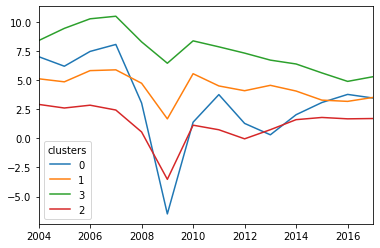

In [0]:
import numpy as np
# Serie original
np.transpose(df.groupby('clusters').mean().iloc[[0,1,3,2],0:len(df)]).plot()

In [0]:
df[df['clusters']==0]

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,clusters
Country Name,,,,,,,,,,,,,,,
United Arab Emirates,9.566437,4.855141,9.837320,3.184390,3.191836,-5.242922,1.602810,6.930272,4.484626,5.053346,4.398697,5.064702,2.988442,0.790400,0
Argentina,9.029573,8.851660,8.047152,9.007651,4.057233,-5.918525,10.125398,6.003952,-1.026420,2.405324,-2.512615,2.731160,-2.080328,2.668590,0
Armenia,10.467842,13.865711,13.198004,13.749202,6.900000,-14.149989,2.200000,4.700000,7.200000,3.300000,3.600000,3.200000,0.200000,7.500000,0
Antigua and Barbuda,5.736460,6.412405,12.728507,9.259421,-0.030133,-12.107536,-7.200024,-2.079127,3.506609,-0.103865,4.658127,4.025737,5.589741,3.032606,0
Bulgaria,6.435358,7.123511,6.874358,7.344422,6.021883,-3.586146,1.324088,1.914906,0.030970,0.493921,1.837521,3.471186,3.936758,3.811248,0
Bosnia and Herzegovina,6.099967,8.759257,5.417270,5.855585,5.426727,-3.002753,0.872151,0.958953,-0.821729,2.351034,1.148038,3.088224,3.145658,3.163559,0
Central African Republic,5.994884,0.908211,4.771085,4.607535,2.054131,8.587260,4.630818,4.194615,5.053761,-36.037426,0.117267,4.562808,5.006286,4.457283,0
Cabo Verde,10.197073,6.912458,7.983750,15.170688,6.650521,-1.270426,1.466790,3.968886,1.081918,0.802798,0.611213,1.006864,4.705792,4.013257,0
Cyprus,5.026348,4.852991,4.713822,5.098037,3.646777,-2.015241,1.335403,0.403430,-2.878100,-5.799305,-1.311465,1.962304,4.812188,4.468879,0


In [0]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df[df['clusters']==1])

                            2004       2005       2006       2007       2008  \
Country Name                                                                   
Albania                 5.509999   5.529915   5.900084   5.979982   7.499970   
Arab World              9.343619   5.716352   6.496294   4.571479   5.819175   
Australia               4.055503   3.204199   2.794529   3.844301   3.657944   
Burundi                 4.833658   0.900000   5.413807   3.451952   4.861713   
Benin                   4.429629   1.711578   3.947014   5.986516   4.889899   
Burkina Faso            4.478474   8.661862   6.253159   5.655005   7.294498   
Bahrain                 6.980947   6.768940   6.468568   8.292444   6.245128   
Belarus                11.449743   9.400002   9.999995   8.600007  10.199999   
Bolivia                 4.173294   4.421435   4.797009   4.564383   6.148497   
Brazil                  5.759965   3.202131   3.961989   6.069871   5.094195   
Botswana                2.705822   4.556

In [0]:
df[df['clusters']==2]

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,clusters
Country Name,,,,,,,,,,,,,,,
Aruba,7.911565,1.214349,1.050607,1.800226,-0.090708,-10.519748,-3.685030,3.446055,-1.369863,4.198232,0.848228,-0.450586,-0.211225,1.330511,2
Andorra,7.647870,7.396983,4.536353,0.040011,-8.590004,-3.690654,-5.358826,-4.646543,-1.615218,0.351645,2.277683,0.842204,1.889124,1.724022,2
American Samoa,0.538358,-0.401606,-4.166667,1.963534,-2.613480,-4.237288,0.442478,0.293686,-4.392387,-2.756508,0.944882,1.248050,-2.619414,-5.379747,2
Austria,2.735119,2.244067,3.454041,3.727415,1.460425,-3.764580,1.837095,2.922798,0.680444,0.025504,0.661275,1.142980,2.039575,2.550881,2
Belgium,3.634853,2.094266,2.506140,3.448976,0.783158,-2.253172,2.744231,1.798306,0.234779,0.200662,1.254677,1.739580,1.452552,1.734390,2
Bahamas The,0.882840,3.395356,2.516849,1.446545,-2.323967,-4.175260,1.538777,0.612897,3.086687,-0.410429,-0.147989,1.044960,-1.689550,1.437191,2
Belize,4.648087,2.578009,4.581600,1.105586,3.228856,0.670801,3.383472,2.162607,2.937813,0.851935,3.692371,3.431950,-0.588024,1.437289,2
Barbados,1.406905,3.975204,5.668591,1.764284,0.123207,-3.972928,0.265446,0.657294,0.281154,0.009044,0.018086,0.904159,2.007168,1.000000,2
Brunei Darussalam,0.504318,0.387507,4.397720,0.154582,-1.939715,-1.764536,2.598966,3.745318,0.912842,-2.126029,-2.349747,-0.566815,-2.465515,1.328751,2


In [0]:
df[df['clusters']==3]

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,clusters
Country Name,,,,,,,,,,,,,,,
Afghanistan,1.414118,11.229715,5.357403,13.826320,3.924984,21.390528,14.362441,0.426355,12.752287,5.600745,2.724543,1.451315,2.260314,2.665292,3
Angola,10.952862,15.028915,11.547683,14.010018,11.166138,0.858713,4.859220,3.471981,8.542147,4.954590,4.822626,0.943576,-2.580097,-0.147207,3
Azerbaijan,9.253801,27.961538,34.466209,25.463216,10.591437,9.369503,4.788833,-1.572998,2.202939,5.842673,2.797289,1.050751,-3.064200,-0.282011,3
Bangladesh,5.239533,6.535945,6.671905,7.058599,6.013790,5.045125,5.571802,6.464384,6.521435,6.013610,6.061059,6.552653,7.113489,7.284184,3
Bhutan,5.896408,7.122560,6.849366,17.925825,4.768354,6.657224,11.730854,7.890914,5.071710,2.142497,5.745455,6.644564,8.022101,4.629101,3
China,10.111223,11.395776,12.719479,14.231388,9.654289,9.399813,10.636140,9.550914,7.859627,7.768615,7.299519,6.905317,6.736675,6.757008,3
Congo Dem. Rep.,6.738374,6.135151,5.320980,6.259478,6.225894,2.855064,7.107977,6.874671,7.086899,8.481957,9.470288,6.916188,2.399379,3.726948,3
Ethiopia,13.572603,11.818766,10.834727,11.456167,10.788522,8.802553,12.550538,11.178296,8.647812,10.582270,10.257493,10.392463,9.433483,9.503859,3
Ghana,5.600000,5.900004,6.399913,4.346819,9.149799,4.844487,7.899712,14.047124,9.292789,7.312525,2.897439,2.178207,3.447793,8.143446,3


Los resultados parecen concordar con los mostrados en el clúster SOM por lo que se pueden considerar consistentes.